<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Regularization Techniques**


Estimated time needed: **30** minutes


In this lab, you will learn five regularization techniques that are commonly used in training neural networks. You will see how they are implemented using Keras and the result of applying each of them on a real world dataset.


## Table of Contents

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>     
    </li>
    <li><a href="https://#Overfitting">Overfitting</a></li>
    <li><a href="https://#L2-Regularization">L2 Regularization</a></li> 
    <li><a href="https://#L1-Regularization">L1 Regularization</a></li>
    <li><a href="https://#Dropout">Dropout</a></li> 
    <li><a href="https://#Batch-Normalization">Batch Normalization</a></li>
    <li><a href="#Example 1: Apply regularization techniques on simulated data">Example 1: Apply regularization techniques on simulated data</a></li>
    <li><a href="#Example 2: Spam Classification">Example 2: Spam Classification</a></li>
</ol>


## Objectives

After completing this lab you will be able to:

*   Understand how the regularization techniques (L1, L2, Dropout, BatchNorm) work for neural networks.
*   Describe the difference between L1 and L2 regularization.
*   Apply the four types of regularization when training neural networks.


***


## Setup


For this lab, we will be using the following libraries:

*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`Pillow`](https://pillow.readthedocs.io/en/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for image processing functions.
*   [`OpenCV`](https://docs.opencv.org/4.x/index.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for other image processing functions.
*   [`tensorflow`](https://www.tensorflow.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and neural network related functions.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run these notebook commands in a different Jupyter environment (like Watson Studio or Anaconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the following code cell.


In [ ]:
# All Libraries required for this lab are listed, as follows. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy numpy==1.22.3 matplotlib==3.5.1 tensorflow==2.9.0 opencv-python==4.5.5.62

# Note: If your environment doesn't support "!mamba install", use "!pip install --user"
!pip install --upgrade tensorflow
# RESTART YOUR KERNEL AFTERWARD AS WELL

You will need the nltk library for this lab, make sure to install it.


In [1]:
%%capture
!pip install nltk

### Importing Required Libraries

*We recommend you import all required libraries in one place, as follows:*


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float

### Defining Helper Functions


This function helps prepare the SMS Spam dataset.


In [3]:
def prepare_data():
    try:
        data = pd.read_csv("spam.csv", encoding='latin-1')
    except FileNotFoundError:
        print("Data file not found, make sure it's downloaded.")
        
    data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
    data.rename(columns={"v1": "label", "v2": "text"}, inplace=True)
    data.label = data['label'].map({'ham':0, 'spam':1})
    data['Count'] = data['text'].apply(lambda x: len(x))
    
    sw=stopwords.words("english")
    vectorizer = TfidfVectorizer(stop_words=sw, binary=True)

    X = vectorizer.fit_transform(data.text).toarray()
    y = data.label
    
    return X, y

This function plots the loss and accuracy curve from the training history of a neural network.


In [4]:
def plot_metrics(history):
    fig = plt.figure(figsize=(10,5))
    for i, metric in enumerate(['accuracy', 'loss']):
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.subplot(1,2,i+1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])


## Overfitting


 In the following figure, we see a two-class classification problem. The red points represent one class, and the blue points represent the second class. The actual decision boundary is shown in black. Most points are in the correct region, but several samples are in the incorrect region; this could be for many reasons, such as noise or outliers. The key point is that you do not expect data points of these classes in these regions.

The second model in green is meant to approximate the decision boundary; this model classifies the data points, even the data points in the incorrect regions. This model does not generalize well. This is because most data points will not be in those regions. As a result, the data will do poorly on data not from the original dataset, like data in the real world. This is called **overfitting**.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/Overfitting.png" width="40%"></center>

<p style="text-align:center">
    <a href="https://en.wikipedia.org/wiki/Overfitting">Source: Wikipedia</a>
</p>

To combat overfitting or high variance, we introduce four regularization techniques in this lab for you to choose from the next time you train your neural network. They are:

- L2 (Ridge) regularization
- L1 (Lasso) regularization
- Dropout
- Batch Normalization 
- Data shuffling


## L2 Regularization


L2 regularization is perhaps the most common form of regularization analogous to the penalty term in  **Ridge regression**. It penalizes the squared magnitude of the weights $\boldsymbol w$ by adding the term $\frac12 \lambda w^2$ to the objective function that the algorithm is trying to optimize. $\lambda$ is the regularization strength, also called the **shrinkage parameter** which can be tuned during training. 

The regularization term is defined as the Euclidean norm of the weight matrices, which sums over all the squared weights. It is multiplied by $\frac12$ so that when the gradient is calculated we get $\lambda w$.

As the shrinkage parameter approaches infinity, the weights are driven down to near zero but **will not be exactly zero**. 


### Using L2 Regularization in Keras

In Keras, regularization penalties are applied on a per-layer basis, that is, you specify the name of the regularizer API as you add a layer to the network. The `tf.keras.regularizers` module has a built-in L2 class that you can call using the following:


In [5]:
tf.keras.regularizers.l2(l=0.01) 

This object can be passed as an argument to a Dense layer:


In [6]:
dense_layer = Dense(32, 
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(l=0.01))

## L1 Regularization

L1 regularization is another common form of regularization. It penalizes large weights $\boldsymbol w$ by adding the term $\lambda |w|$ to the objective function, where $\lambda$ is the regularization strength. 

What differentiates L1 from L2 is that, when $\lambda$ approaches infinity, L1 regularization can shrink the weights of the less important features to zero, which would be very useful if you also want automatic feature selection during training. 

<p style='color: blue'>The following figure illustrates how L1 and L2 work differently:</p>

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/L12_1.png" width="65%"></center>

<p style="text-align:center; color:gray">Source: An Introduction to Statistical Learning</p>


In the figure above, the red ellipses represent the contours of the loss function that needs to be optimized during training, and the green areas on the left and right represent the **feasible regions** of the L1 and L2 constaints respectively. 

In the case of L1 (left), the ellipse would be able to intersect with the feasible region on an axis, which is when the weights become zero. However, for L2 (right), due to the round shape of the feasible region; that is, the L2 norm, the ellipse wouldn't intersect with the green circle on an axis, which is why the weights regularized by L2 can be close to zero but not equal to zero.

We can also combine the L1 regularization and the L2 regularization to obtain the **Elastic Net regularization**: $\frac12 \lambda_1 w^2 + \lambda_2 |w|$. $\lambda_1$ and $\lambda_2$ can be tuned as hyperparameters during training.


### Using L1 Regularization in Keras

Similar to how we used L2, `tf.keras.regularizers` module also has a built-in L1 class:


In [7]:
dense_layer = Dense(32, 
            activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l1(l=0.01))

If you don't need to specify a value for the regularization strength, you can also pass a string value to the `kernel_regularizer` argument:


In [8]:
dense_layer = Dense(32, 
                activation="relu", 
                kernel_regularizer="l1")

## Dropout

During training, Dropout will keep a neuron active with some probability $\boldsymbol p$ (a hyperparameter), or set it to zero otherwise. This regularization technique approximates training a large number of different neural networks in parallel.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/DO_1.png" width="60%"></center>

Picture from the [Dropout paper](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)

Dropout can be interpreted as sampling a neural network within the full neural network and only updating the weights of the sampled network. By doing so, each iteration is using a different model architecture and has a different "view" of the configured layers. This adds noise to the training process and perhaps breaks up situations where network layers co-adapt to correct prior mistakes, making the network more robust.

Note that **Dropout is not used during prediction**.


### Using Dropout in Keras

In Keras, Dropout can be applied using the Dropout class from **keras.layers**. A dropout rate can be specified when creating the dropout layer, which is the percentage of neurons that will be turned off during one update.


In [9]:
from tensorflow.keras.layers import Dropout

dropout_layer = Dropout(rate=0.2)

## Batch Normalization

Training deep neural networks is complicated, because the distribution of each layer's inputs changes as the weights of the previous layers get updated during back propagation. This can result in the learning algorithm always pursuing a moving target. In the [original paper](https://arxiv.org/abs/1502.03167) of Batch Normalization, the change in the distribution of inputs to layers in the network is referred to as **"internal covariate shift"**. This slows down the training by requiring lower learning rates and careful parameter initialization, making it hard for the model to generalize well. Sometimes, if the training samples are statistically too different from the testing samples, it is considered a covariate shift.


### What is Batch Normalization?

Batch normalization is a technique for training very deep neural networks that normalizes the inputs to a layer for every mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

**Batch**, or **mini-batch**, is a collection of samples that will be passed through the network at one time for the weights update. **Normalization** is the process of transforming the data to have a mean 0 and a standard deviation 1 (thus follows the standard normal distribution). 

In a neural network, batch normalization is achieved through a normalization layer between the fully connected Dense layers, which fixes the means and variances of each layer's inputs. This way, there is not much change in the distribution of each layer input, and the layers in the network can learn from back-propagation simultaneously without having to wait for the previous layers to learn. This accelerates the training process.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/BN_6.png" width="70%"></center>

Image credits to [Ilango Rajagopal](https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85)


### How does Batch Normalization work?

Denote by $\boldsymbol B$ a mini-batch of size $\boldsymbol m$ of the training set, for a layer with **_d_**-dimensional input $x = (x^{(1)},...,x^{(d)})$, each dimension of its input is then normalized as:
$$
\hat{x}_{i}^{k} = \frac {x_i ^{k}-\mu_B^{k}} {\sqrt{{\sigma_B^{k}}^2 +\epsilon}}
$$

where $k \in [1,d]$and $i \in [1,m]$; $\mu_B^{k}$ and ${\sigma_B^{k}}^2$are the **per dimension mean and variance** of $\boldsymbol B$ such that:


$$
\mu_B^{k} = \frac{1}{m} \sum_{i=1}^m x_i^{k}, {\sigma_B^{k}}^2 = \frac{1}{m} \sum_{i=1}^m (x_i^{k}-\mu_B^{k})^2
$$


$\epsilon$ is added in the denominator for numerical stability and is an arbitrarily small constant. The resulting normalized activation $\hat{x}^{k}$ has zero mean and unit variance if $\epsilon$ is not taken into account. To restore the representation power of the network, a transformation step then follows as

$$
y_i^{k} = \gamma^{k} \hat{x}_{i}^{k} +\beta^{k}
$$

where the parameters $\gamma^{k}$ and $\beta^{k}$ are subsequently learned in the optimization process. You can refer to [wikipedia](https://en.wikipedia.org/wiki/Batch_normalization) for more mathematical details of batch normalization.


<p style='color: blue'>What are the benefits of Batch Normalization?</p>

1. It tackles the internal covariate shift issue by always normalizing the input signals, thus accelerating the training of deep neural nets and increasing the generalization power of the networks.
2. It makes the optimization landscape smoother, reducing the magnitude of variations in the gradient and the loss, making the training faster and easier.
3. It acts as a regularizer by introducing random noises, as each minibatch at each layer is normalized using its own mean and standard deviation during training.


### Using Batch Normalization in Keras

In Keras, you can add a Batch Norm layer between the Dense layers by calling `BatchNormalization()` from **keras.layers**. Here is a code example:


In [10]:
from tensorflow.keras.layers import Dense, BatchNormalization

batchnorm_layer = BatchNormalization()

## Example 1: Apply regularization techniques on simulated data

In this example, we will use the **generate_data** function to simulate a degree-3 polynomial dataset with some random noise. We will intentionally overfit the data by creating polynomial features of the data, and then we will observe whether the four regularization techniques can mitigate overfitting in this case.


Let's first visualize the polynomial data:


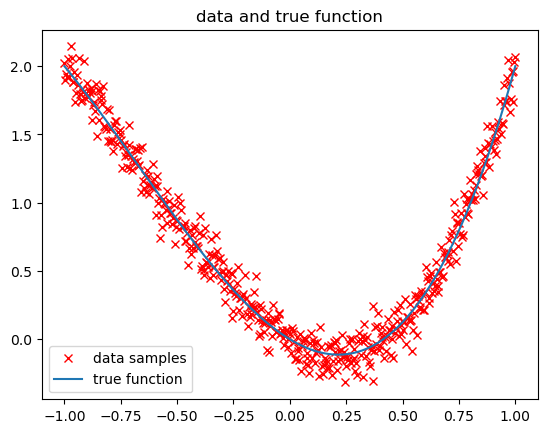

In [11]:
def generate_data(seed=43,std=0.1,samples=500):
    np.random.seed(seed)
    X =np.linspace(-1,1,samples)
    f = X**3 +2*X**2 -X 
    y=f+np.random.randn(samples)*std
    
    return X, y


X,y = generate_data()
f = X**3 +2*X**2 -X
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.title("data and true function")
plt.legend()
plt.show()

let's also add some outliers to y:


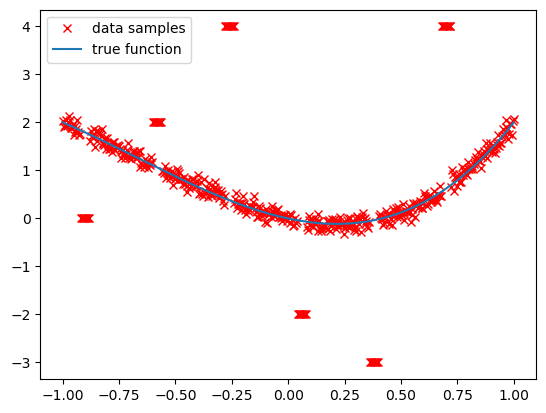

In [12]:
y[20:30] = 0
y[100:110] = 2
y[180:190] = 4
y[260:270] = -2
y[340:350] = -3
y[420:430] = 4

plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.legend()
plt.show()

Let's use an overly complex neural network to fit our simulated data.


In [13]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(1000, activation='relu',input_shape=(1,)))
model.add(Dense(120,activation='relu'))
model.add(Dense(120,activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model.fit(X, y,  epochs=20, batch_size=100)

Epoch 1/20
5/5 [==============================] - 1s 12ms/step - loss: 1.5989
Epoch 2/20
5/5 [==============================] - 0s 14ms/step - loss: 1.1599
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.9784
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.9801
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.9082
Epoch 6/20
5/5 [==============================] - 0s 11ms/step - loss: 0.8958
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.8576
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.8266
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.7951
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.7757
Epoch 11/20
5/5 [==============================] - 0s 10ms/step - loss: 0.7543
Epoch 12/20
5/5 [==============================] - 0s 10ms/step - loss: 0.7413
Epoch 13/20
5/5 [==============================] - 0s 11ms/st

When we plot out the original data and the predictions, we can see that because the model's weights are not regularized, it tends to over fit  on new data: 


16/16 [==============================] - 0s 2ms/step


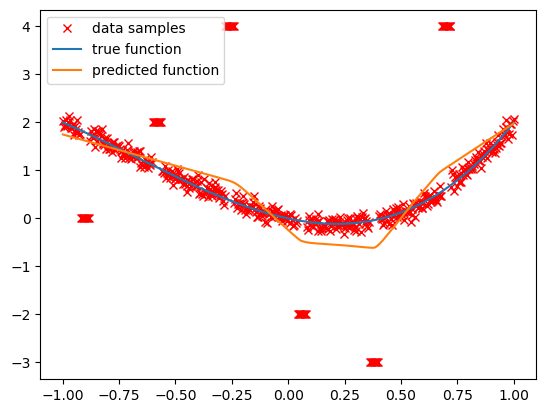

In [14]:
y_pred = model.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()
plt.show()

We can also calculate the mean square error:


In [15]:
no_reg = np.mean((y-y_pred)**2)
print(f"Mean squared error is {no_reg}\n")

Mean squared error is 1.9527829795814333



Now let's apply the four regularization techniques: **L1, L2, Drop out, and Batch Normalization** and see which works best for our data!


### L1 (Lasso)


In [16]:
model_l1 = Sequential()

model_l1.add(Dense(1000, activation='relu',input_shape=(1,),kernel_regularizer=keras.regularizers.l1(l=0.01)))
model_l1.add(Dense(120,activation='relu',kernel_regularizer=keras.regularizers.l1(l=0.001)))
model_l1.add(Dense(120,activation='relu'))
model_l1.add(Dense(1))
model_l1.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_l1.fit(X, y,  epochs=20, batch_size=100)

Epoch 1/20
5/5 [==============================] - 1s 15ms/step - loss: 6.2437
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 5.4686
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 4.7539
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 4.2567
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 3.8223
Epoch 6/20
5/5 [==============================] - 0s 11ms/step - loss: 3.3927
Epoch 7/20
5/5 [==============================] - 0s 15ms/step - loss: 3.0264
Epoch 8/20
5/5 [==============================] - 0s 15ms/step - loss: 2.6854
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 2.3730
Epoch 10/20
5/5 [==============================] - 0s 11ms/step - loss: 2.1022
Epoch 11/20
5/5 [==============================] - 0s 14ms/step - loss: 1.8687
Epoch 12/20
5/5 [==============================] - 0s 11ms/step - loss: 1.6707
Epoch 13/20
5/5 [==============================] - 0s 10ms/st

We can plot the model, we see the model tracks the data: 


16/16 [==============================] - 0s 2ms/step


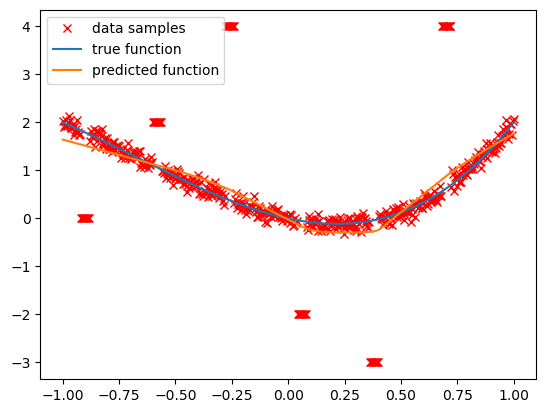

In [17]:
y_pred = model_l1.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred,label="predicted function")
plt.legend()
plt.show()

We can also calculate the mean square error; we see L1 regulation decreases the error:


In [18]:
l1 = np.mean((y-y_pred)**2)
print(f"Mean squared error is {l1}\n")

Mean squared error is 1.72257976338827



### L2 (Ridge)


In [19]:
model_l2 = Sequential()

model_l2.add(Dense(1000, activation='relu',input_shape=(1,),kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_l2.add(Dense(120,activation='relu',kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_l2.add(Dense(120,activation='relu',kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_l2.add(Dense(1))
model_l2.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_l2.fit(X, y, validation_split=0.2, epochs=20, batch_size=40)

Epoch 1/20
10/10 [==============================] - 1s 47ms/step - loss: 1.1189 - val_loss: 3.8509
Epoch 2/20
10/10 [==============================] - 0s 15ms/step - loss: 0.7568 - val_loss: 5.0689
Epoch 3/20
10/10 [==============================] - 0s 17ms/step - loss: 0.7259 - val_loss: 4.1975
Epoch 4/20
10/10 [==============================] - 0s 14ms/step - loss: 0.7057 - val_loss: 4.0428
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6935 - val_loss: 4.3870
Epoch 6/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6963 - val_loss: 4.1200
Epoch 7/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6894 - val_loss: 3.7311
Epoch 8/20
10/10 [==============================] - 0s 13ms/step - loss: 0.6787 - val_loss: 3.6184
Epoch 9/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6781 - val_loss: 3.4140
Epoch 10/20
10/10 [==============================] - 0s 24ms/step - loss: 0.6814 - val_loss: 3.3528
Epoch 11/

We can plot the model, we can also calculate the mean square error; we see L2 regulation can also improve the result by a little bit:


16/16 [==============================] - 0s 2ms/step


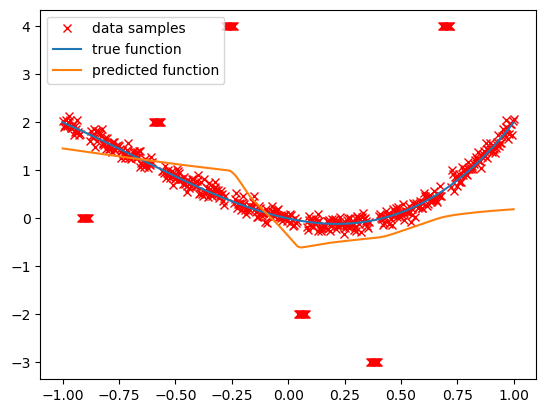

In [20]:
y_pred = model_l2.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [21]:
l2 = np.mean((y-y_pred)**2)
print(f"Mean squared error is {l2}\n")

Mean squared error is 1.8957906292633544



### Dropout


In [22]:
model_dp = Sequential()

model_dp.add(Dense(1000, activation='relu',input_shape=(1,)))
model_dp.add(Dropout(0.1))
model_dp.add(Dense(120,activation='relu'))
model_dp.add(Dropout(0.1))
model_dp.add(Dense(120,activation='relu'))
model_dp.add(Dropout(0.1))
model_dp.add(Dense(1))
model_dp.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_dp.fit(X, y, validation_split=0.2, epochs=20, batch_size=40)

Epoch 1/20
10/10 [==============================] - 1s 29ms/step - loss: 1.0131 - val_loss: 3.6376
Epoch 2/20
10/10 [==============================] - 0s 16ms/step - loss: 0.7432 - val_loss: 4.9299
Epoch 3/20
10/10 [==============================] - 0s 14ms/step - loss: 0.7194 - val_loss: 4.2333
Epoch 4/20
10/10 [==============================] - 0s 16ms/step - loss: 0.7042 - val_loss: 4.2534
Epoch 5/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6897 - val_loss: 4.4129
Epoch 6/20
10/10 [==============================] - 0s 27ms/step - loss: 0.7050 - val_loss: 4.2021
Epoch 7/20
10/10 [==============================] - 0s 27ms/step - loss: 0.6889 - val_loss: 3.8715
Epoch 8/20
10/10 [==============================] - 0s 29ms/step - loss: 0.6729 - val_loss: 3.7436
Epoch 9/20
10/10 [==============================] - 0s 24ms/step - loss: 0.6601 - val_loss: 3.2421
Epoch 10/20
10/10 [==============================] - 0s 29ms/step - loss: 0.6638 - val_loss: 3.5409
Epoch 11/

Let's plot the prediction and calculate the mean square error;


16/16 [==============================] - 0s 2ms/step


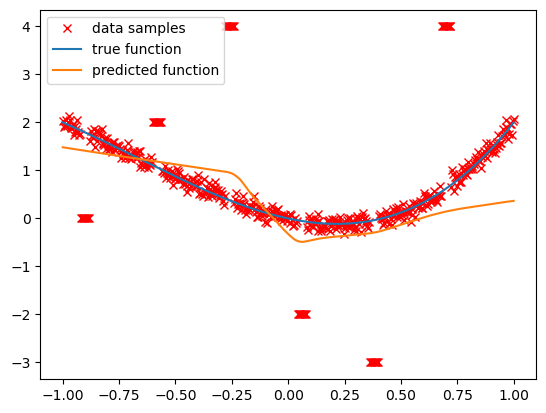

In [23]:
y_pred = model_dp.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [24]:
dp = np.mean((y-y_pred)**2)
print(f"Mean squared error is {dp}\n")

Mean squared error is 1.792283133824768



### Batch Norm


In [25]:
model_bn = Sequential()

model_bn.add(Dense(1000, activation='relu',input_shape=(1,)))
model_bn.add(BatchNormalization())
model_bn.add(Dense(120,activation='relu'))

model_bn.add(Dense(120,activation='relu'))
model_bn.add(Dense(1))
model_bn.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_bn.fit(X, y, validation_split=0.2, epochs=20, batch_size=40)

Epoch 1/20
10/10 [==============================] - 1s 30ms/step - loss: 0.8405 - val_loss: 2.7354
Epoch 2/20
10/10 [==============================] - 0s 17ms/step - loss: 0.7869 - val_loss: 2.6561
Epoch 3/20
10/10 [==============================] - 0s 17ms/step - loss: 0.7898 - val_loss: 2.5139
Epoch 4/20
10/10 [==============================] - 0s 16ms/step - loss: 0.8009 - val_loss: 2.6683
Epoch 5/20
10/10 [==============================] - 0s 16ms/step - loss: 0.8396 - val_loss: 2.8030
Epoch 6/20
10/10 [==============================] - 0s 16ms/step - loss: 0.7066 - val_loss: 2.7301
Epoch 7/20
10/10 [==============================] - 0s 16ms/step - loss: 0.7322 - val_loss: 2.6778
Epoch 8/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6802 - val_loss: 2.6897
Epoch 9/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6397 - val_loss: 2.7232
Epoch 10/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6236 - val_loss: 2.6736
Epoch 11/

We can observe that due to a stronger regularization of Batch Normalization, the model does not seem to fit the data very well. However, the mean square error actually shows a big improvement.


16/16 [==============================] - 0s 2ms/step


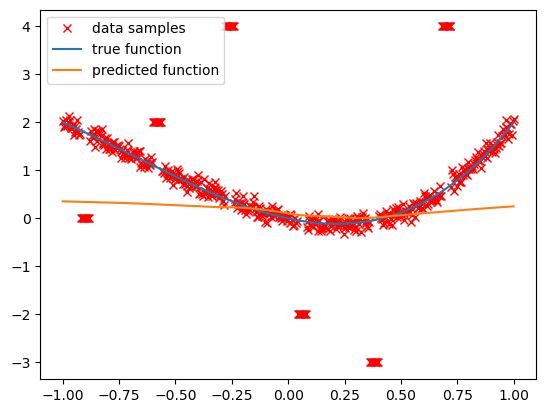

In [26]:
y_pred = model_bn.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [27]:
bn = np.mean((y-y_pred)**2)
print(f"Mean squared error is {bn}\n")

Mean squared error is 1.5674260745232813



## Data Shuffling

To apply data shuffling to avoid overfitting, we can simpy call `shuffle=True` when fitting the model.


In [28]:
model_sh = Sequential()

model_sh.add(Dense(1000, activation='relu',input_shape=(1,)))
model_sh.add(Dense(120,activation='relu'))
model_sh.add(Dense(120,activation='relu'))
model_sh.add(Dense(1))

model_sh.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_sh.fit(X, y, validation_split=0.2, epochs=20, batch_size=40,shuffle=True)

Epoch 1/20
10/10 [==============================] - 1s 27ms/step - loss: 1.1558 - val_loss: 3.6167
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 0.7193 - val_loss: 4.8155
Epoch 3/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6965 - val_loss: 4.2140
Epoch 4/20
10/10 [==============================] - 0s 17ms/step - loss: 0.6839 - val_loss: 4.3823
Epoch 5/20
10/10 [==============================] - 0s 19ms/step - loss: 0.6710 - val_loss: 3.8585
Epoch 6/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6650 - val_loss: 3.6637
Epoch 7/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6589 - val_loss: 3.5015
Epoch 8/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6575 - val_loss: 3.2750
Epoch 9/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6653 - val_loss: 2.9203
Epoch 10/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6592 - val_loss: 3.4612
Epoch 11/

We can also calculate the mean square error on the data. Data shuffling doesn't seem to be very effective for our data.


16/16 [==============================] - 0s 2ms/step


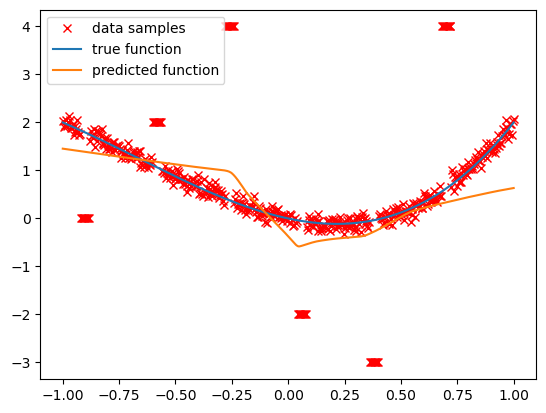

In [29]:
y_pred = model_sh.predict(X)

plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [30]:
sh = np.mean((y-y_pred)**2)
print(f"Mean squared error is {sh}\n")

Mean squared error is 1.7620020993682928



Let's compare the mean squared errors of the networks trained using different regularization techniques:


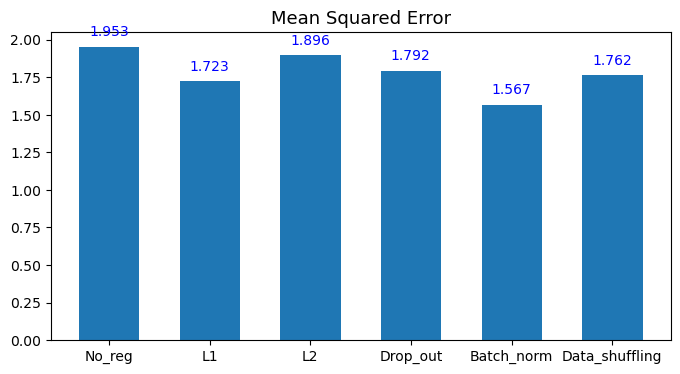

In [31]:
names = ['No_reg','L1','L2','Drop_out','Batch_norm','Data_shuffling']
error = [no_reg, l1, l2, dp, bn, sh]

plt.figure(figsize=(8, 4))
plt.bar(names, error, width=0.6)
plt.title("Mean Squared Error", fontsize=13)

for i, err in enumerate(error):
    plt.text(i-0.2, err+0.1, str(round(err,3)), color='blue', va='center') 

Given the comparison of the mean squared errors, we can conclude that Batch Normalization works best for the simulated dataset. However, one takeaway I hope you to have is that for model training or machine learning in general, there are no cookie-cutter solutions for issues such as overfitting. There are no strict rules as to which technique is most effective when working with one type of dataset, so I would suggest you just try these techniques out and pick the one that you deem is the best (based on an evaluation metric) for your problem!

Now, let's move on to a real world dataset.


## Example 2: Spam Classification

In this example, we will dive into a real world application, which is a spam classification problem. We will work with the [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) from Kaggle and use neural networks for classifying a message as either Spam or Ham (not spam).

We first download and display the raw dataset:


In [32]:
import skillsnetwork

await skillsnetwork.download("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/data/spam.csv")

Saved as 'spam.csv'


In [33]:
data = pd.read_csv("spam.csv", encoding="latin-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


By calling the helper function **prepare_data**, we obtain a matrix $\boldsymbol X$ which contains the pre-processed text data (mainly using the **TfidfVectorizer** from scikit-learn's **feature_extraction** module) and an object $\boldsymbol y$ which contains the labels of the messages. 

There are 5572 text messages that will be classified as either spam **(1)** or non-spam **(0)**, and they are 8536-dimensional data.


In [34]:
X, y = prepare_data()
X.shape, y.shape

((5572, 8536), (5572,))

### Model Configuration and Training


The **get_model** function provides the layer configuration ane the training of a neural network for different specifications of the regularization technique used. For example, by setting `reg='L1'`, the network's Dense layers will be regularized by L1, and then at the end of the training, the loss and accuracy curve of the train and validation set will be plotted.


In [35]:
input_dim = X.shape[1]
   
def get_model(reg=None, epochs=10):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
    if reg=="L1":
        model.add(Dense(256, activation='relu', kernel_regularizer="l1"))
        model.add(Dense(64, activation='relu', kernel_regularizer="l1"))
    elif reg=="L2":
        model.add(Dense(256, activation='relu', kernel_regularizer="l2"))
        model.add(Dense(64, activation='relu', kernel_regularizer="l2"))
    elif reg=="Dropout":
        model.add(Dropout(0.2))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
    elif reg=="BatchNorm":
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())  
    else:
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))  
 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer="adam",
                 metrics=["accuracy"])
    history = model.fit(X, y, batch_size=64, validation_split=0.2,
              epochs=epochs)
    plot_metrics(history)


### Baseline: No Regularization


Epoch 1/10
70/70 [==============================] - 12s 159ms/step - loss: 0.2638 - accuracy: 0.8694 - val_loss: 0.1327 - val_accuracy: 0.9776
Epoch 2/10
70/70 [==============================] - 10s 146ms/step - loss: 0.0776 - accuracy: 0.9917 - val_loss: 0.0863 - val_accuracy: 0.9803
Epoch 3/10
70/70 [==============================] - 10s 150ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0842 - val_accuracy: 0.9830
Epoch 4/10
70/70 [==============================] - 12s 168ms/step - loss: 3.1585e-04 - accuracy: 1.0000 - val_loss: 0.1010 - val_accuracy: 0.9812
Epoch 5/10
70/70 [==============================] - 11s 150ms/step - loss: 1.3433e-04 - accuracy: 1.0000 - val_loss: 0.1046 - val_accuracy: 0.9812
Epoch 6/10
70/70 [==============================] - 10s 149ms/step - loss: 7.6610e-05 - accuracy: 1.0000 - val_loss: 0.1083 - val_accuracy: 0.9812
Epoch 7/10
70/70 [==============================] - 10s 149ms/step - loss: 4.8320e-05 - accuracy: 1.0000 - val_loss: 0.1117 - val_

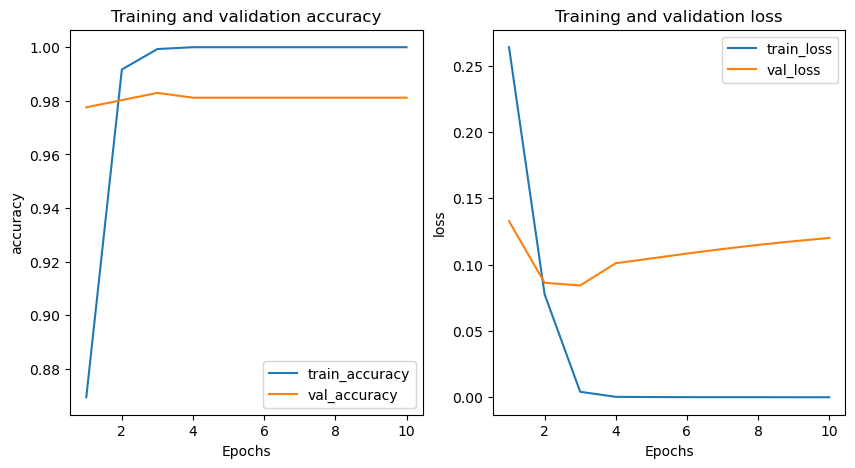

In [36]:
get_model()

You can see that without regularization, our training set accuracy is generally higher than validation accuracy, which means the model is overfitted to the training set.


### L1 Regularization


Epoch 1/10
70/70 [==============================] - 12s 154ms/step - loss: 32.2873 - accuracy: 0.8631 - val_loss: 6.4944 - val_accuracy: 0.8700
Epoch 2/10
70/70 [==============================] - 11s 152ms/step - loss: 2.0867 - accuracy: 0.8649 - val_loss: 0.6454 - val_accuracy: 0.8700
Epoch 3/10
70/70 [==============================] - 10s 146ms/step - loss: 0.5895 - accuracy: 0.8649 - val_loss: 0.5640 - val_accuracy: 0.8700
Epoch 4/10
70/70 [==============================] - 10s 149ms/step - loss: 0.5731 - accuracy: 0.8649 - val_loss: 0.5633 - val_accuracy: 0.8700
Epoch 5/10
70/70 [==============================] - 10s 150ms/step - loss: 0.5730 - accuracy: 0.8649 - val_loss: 0.5631 - val_accuracy: 0.8700
Epoch 6/10
70/70 [==============================] - 12s 168ms/step - loss: 0.5722 - accuracy: 0.8649 - val_loss: 0.5632 - val_accuracy: 0.8700
Epoch 7/10
70/70 [==============================] - 10s 148ms/step - loss: 0.5727 - accuracy: 0.8649 - val_loss: 0.5628 - val_accuracy: 0.870

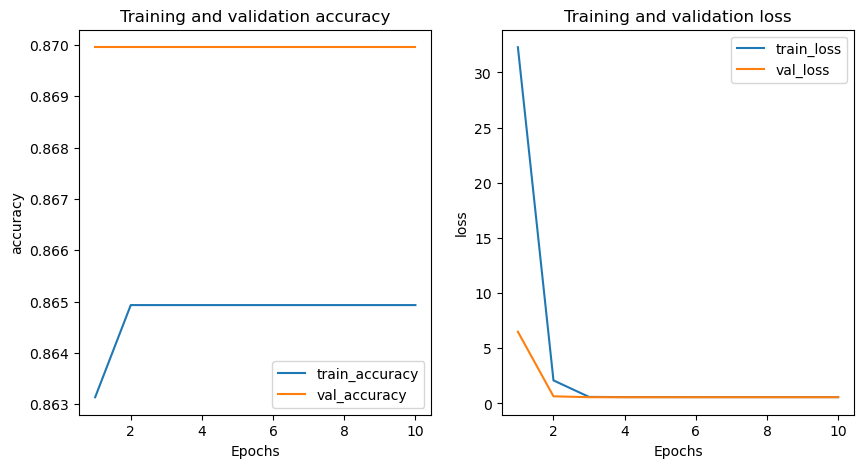

In [37]:
get_model(reg="L1")

With L1 regularization, we can see that the validation accuracy is now higher than the training accuracy, meaning the L1 regularization mitigated the overfitting issue. However, if we look closer at the y-axis, we can see that in fact the accuracy value in general (both train and validation) is lower than the baseline model. 

For the baseline model, the validation accuracy was always above 0.97 even though it's slightly lower than the training accuracy. This indicates that, by using the default L1 regularization with shrinkage strength equals 0.001, our model is underfitting.


### L2 Regularization


Epoch 1/10
70/70 [==============================] - 12s 152ms/step - loss: 2.0848 - accuracy: 0.8685 - val_loss: 0.5552 - val_accuracy: 0.9552
Epoch 2/10
70/70 [==============================] - 12s 167ms/step - loss: 0.2729 - accuracy: 0.9823 - val_loss: 0.1632 - val_accuracy: 0.9803
Epoch 3/10
70/70 [==============================] - 11s 152ms/step - loss: 0.0953 - accuracy: 0.9966 - val_loss: 0.1315 - val_accuracy: 0.9722
Epoch 4/10
70/70 [==============================] - 10s 148ms/step - loss: 0.0632 - accuracy: 0.9993 - val_loss: 0.1102 - val_accuracy: 0.9776
Epoch 5/10
70/70 [==============================] - 10s 150ms/step - loss: 0.0503 - accuracy: 0.9996 - val_loss: 0.1075 - val_accuracy: 0.9767
Epoch 6/10
70/70 [==============================] - 10s 146ms/step - loss: 0.0422 - accuracy: 0.9998 - val_loss: 0.0916 - val_accuracy: 0.9785
Epoch 7/10
70/70 [==============================] - 11s 150ms/step - loss: 0.0356 - accuracy: 0.9998 - val_loss: 0.0901 - val_accuracy: 0.9776

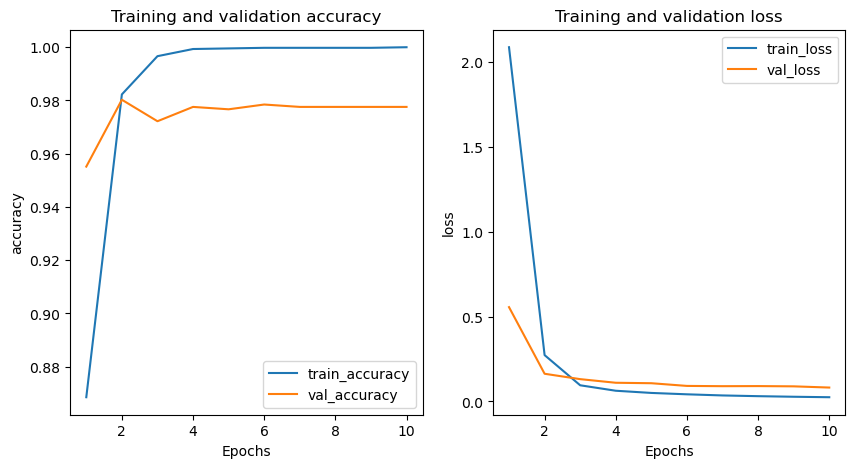

In [38]:
get_model(reg="L2")

With L2 regularization, the gap between training accuracy and validation accuracy narrowed a little bit. The training accuracy was not always 1.0 compared to the baseline and the validation accuracy had more fluctuations than the baseline.


### Dropout


Epoch 1/10
70/70 [==============================] - 12s 152ms/step - loss: 0.2759 - accuracy: 0.8573 - val_loss: 0.1338 - val_accuracy: 0.8744
Epoch 2/10
70/70 [==============================] - 11s 150ms/step - loss: 0.0713 - accuracy: 0.9868 - val_loss: 0.0607 - val_accuracy: 0.9812
Epoch 3/10
70/70 [==============================] - 11s 154ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0789 - val_accuracy: 0.9812
Epoch 4/10
70/70 [==============================] - 10s 148ms/step - loss: 5.1285e-04 - accuracy: 1.0000 - val_loss: 0.0940 - val_accuracy: 0.9812
Epoch 5/10
70/70 [==============================] - 10s 148ms/step - loss: 2.0211e-04 - accuracy: 1.0000 - val_loss: 0.1036 - val_accuracy: 0.9812
Epoch 6/10
70/70 [==============================] - 11s 151ms/step - loss: 1.2716e-04 - accuracy: 1.0000 - val_loss: 0.1064 - val_accuracy: 0.9812
Epoch 7/10
70/70 [==============================] - 11s 152ms/step - loss: 7.1904e-05 - accuracy: 1.0000 - val_loss: 0.1131 - val_

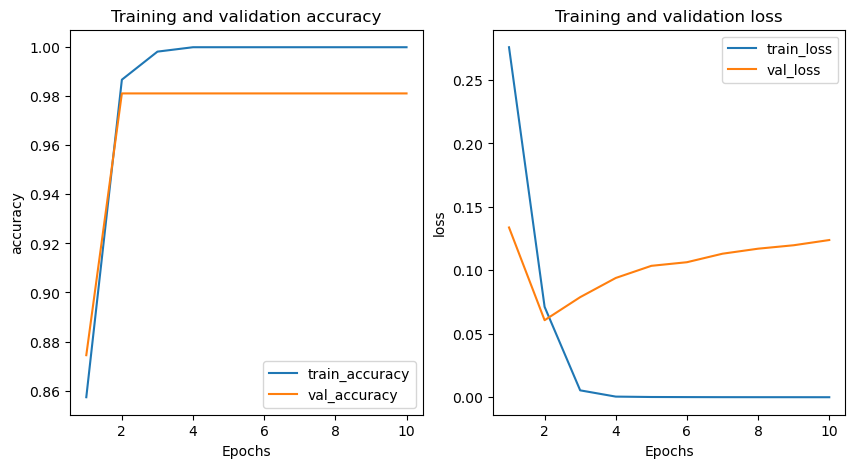

In [39]:
get_model(reg="Dropout")

With dropout, the resulting curves are very similar to the baseline, so perhaps dropout is not very effective in our case.


### Batch Normalization


Epoch 1/10
70/70 [==============================] - 13s 160ms/step - loss: 0.3479 - accuracy: 0.8580 - val_loss: 0.4077 - val_accuracy: 0.8700
Epoch 2/10
70/70 [==============================] - 11s 156ms/step - loss: 0.0762 - accuracy: 0.9888 - val_loss: 0.4579 - val_accuracy: 0.8700
Epoch 3/10
70/70 [==============================] - 10s 149ms/step - loss: 0.0255 - accuracy: 0.9971 - val_loss: 0.5558 - val_accuracy: 0.8700
Epoch 4/10
70/70 [==============================] - 11s 153ms/step - loss: 0.0145 - accuracy: 0.9987 - val_loss: 0.6142 - val_accuracy: 0.8700
Epoch 5/10
70/70 [==============================] - 11s 154ms/step - loss: 0.0088 - accuracy: 0.9996 - val_loss: 0.5492 - val_accuracy: 0.8762
Epoch 6/10
70/70 [==============================] - 10s 150ms/step - loss: 0.0066 - accuracy: 0.9991 - val_loss: 0.4087 - val_accuracy: 0.9040
Epoch 7/10
70/70 [==============================] - 11s 152ms/step - loss: 0.0047 - accuracy: 0.9998 - val_loss: 0.2617 - val_accuracy: 0.9480

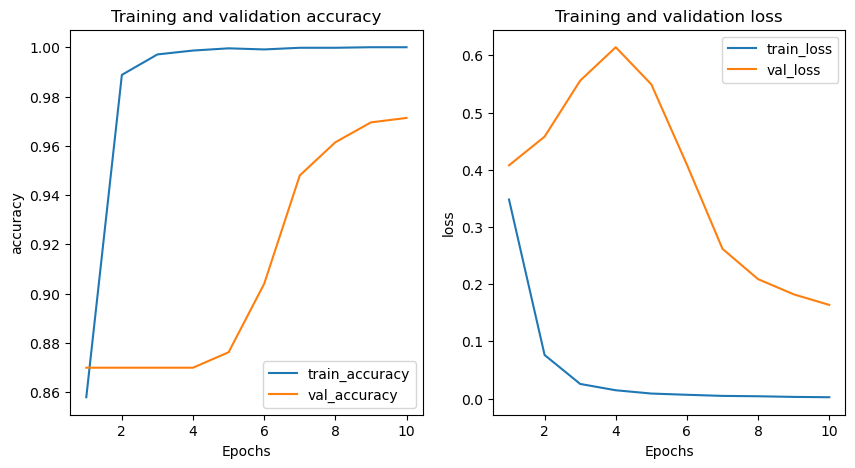

In [42]:
get_model(reg="BatchNorm")

With Batch Norm, the final training accuracy is 1.0 and final validation accuracy is 0.9812, which is slightly higher than before (0.9794). We can conclude that Batch Normalization is a relatively better choice for regularizing neural network training.


## Authors


[Roxanne Li](https://www.linkedin.com/in/roxanne-li/) is a Data Scientist at IBM Skills Network.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By  | Change Description |
| ----------------- | ------- | ----------- | ------------------ |
| 2022-07-18      | 0.1     | Roxanne Li  | Created Lab|
| 2022-09-07      | 0.1     | Steve Hord  | QA pass edits|


Copyright © 2022 IBM Corporation. All rights reserved.
